# EDA + Data Cleansing

In [35]:
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from impyute.imputation.cs import fast_knn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats

# %matplotlib inline
warnings.filterwarnings('ignore')

# set sandbox_mode boolean for image building
* if sandbox_mode = True: faster to run, but images won't be generated

In [36]:
sandbox_mode = False

# define functions

In [37]:
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

### functions related to missing data

In [38]:
def get_missing(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count())
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent_missing'])
    missing_data['percent_missing'] = missing_data['percent_missing']
    missing_data['percent_missing'] = missing_data['percent_missing'].apply(lambda x: round(x,2))
    
    return missing_data

def drop_missing_from_threshold(df, row_threshold, col_threshold):
    row_count, col_count = df.shape
    # drop columns according to threshold of missing; use mask of columns which have less missing than threshold
    df = df.iloc[:, (df_missing['percent_missing'] < col_threshold).to_list()]
    
    # drop row according to threshold of missing
    n_cols = df.shape[1]
    df['ratio_mis'] = df.apply(lambda x: (n_cols - x.count())/n_cols, axis=1)
    df = df[df['ratio_mis']<row_threshold]
    df.drop(['ratio_mis'], axis=1, inplace=True)
    
    # count number of removals
    row_count_new, col_count_new = df.shape
    row_count_removal = row_count - row_count_new
    col_count_removal = col_count - col_count_new
    print('{} rows and {} columns were removed from database'.format(row_count_removal, col_count_removal))
    
    return df

def apply_imputation(df, method = 'knn', k=30, manual_val=-1):
    try:
        assert method in ['knn', 'mode', 'median', -1, 'manual']
    except AssertionError:
        raise ValueError('error: select a correct method for imputation: [knn, mode, median, -1, manual]')
        
    if method == 'knn':
        sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
        numerical_cols, other_cols = get_numerical_mask(df)
        
#         df =  StandardScaler().fit_transform(df) # scale for knn to work properly (it's distance based)

        # start the KNN training
        imputed_training = fast_knn(df[numerical_cols], k=30)

        # retrieve column names
        imp_cols = imputed_training.columns.to_list()
        imputed_training.rename({imp_cols[i]: numerical_cols[i] for i in range(len(imp_cols))}, axis = 1, inplace=True)
        df.reset_index(inplace=True)
        other_cols.append('id')
        df = df[other_cols].merge(imputed_training, left_index=True, right_index=True)
        df.set_index('id', inplace=True)
        
    elif method == 'mode':
        df.fillna(data.mode().iloc[0], inplace=True)
        
    elif method == 'median':
        df.fillna(df.median(), inplace=True)

    elif method == -1:
        df.fillna(-1, inplace=True)
    
    elif method == 'manual':
        df.fillna(manual_val, inplace=True)
        
    try:
        assert df[df.isna().any(axis=1)].shape[0] == 0
    except AssertionError:
        raise ValueError('there are still missing values')
    
    return df

### functions related to outliers

In [39]:
def apply_standard_deviation_tol(df, tol=3):
    #scale data for operation
    df = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols]))
    
    z = np.abs(stats.zscore(df))
    z = pd.DataFrame(z, columns = df.columns, index=df.index)
    z.fillna(0, inplace=True)
    for col in z.columns[2:]:
        z = z[z[col]<tol]
    print("{0:.2%} of data was removed after dealing with outliers".format((df.shape[0]-z.shape[0])/df.shape[0]))
    df = df.loc[z.index, :]
    
    return df

def apply_isolation_forest(df, contamination=0.05):
    clf = IsolationForest(max_samples='auto', contamination=contamination, random_state=42) # contamination='auto' or 0.05
    clf.fit(df)

    outlier_pred = clf.predict(df)
    print('number of outliers:', np.count_nonzero(outlier_pred == -1), 'from a total of {}'.format(len(outlier_pred)))
    print('percentage of outliers: {0:.0%}'.format(np.count_nonzero(outlier_pred == -1)/np.count_nonzero(outlier_pred == 1)))
    
    return outlier_pred

def get_outliers(df, label, cols, method = 'isolation_forest', if_contamination = 0.05, z_tol = 3):

    if method == 'isolation_forest':
        outliers = apply_isolation_forest(df, if_contamination)
    elif method == 'standard_deviation_tol':
        df = apply_standard_deviation_tol(df, z_tol)
    
    print(len(outliers))
    return outliers, label

# Define paths and capture data

In [40]:
inputs = os.path.join('..', 'data', '02_intermediate')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

In [41]:
data               = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
data_test          = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
y_train            = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test             = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

In [42]:
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (559, 13)


,preset_1,preset_2,cycle,temperature,pressure,vibrationx,vibrationy,vibrationz,frequency,lag_1,lag_2,lag_3,anomaly_count_lag10
id,,,,,,,,,,,,,
0,3,6,1.0,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0,0,0,0.0
1,2,4,2.0,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0,0,0,0.0
2,2,1,3.0,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0,0,0,0.0
3,2,3,4.0,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0,0,0,0.0
4,2,5,5.0,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0,0,0,0.0


# get types of columns

In [43]:
# correct data types
for c in ['preset_1', 'preset_2']:
    data[c] = data[c].astype('object')
    
numerical_cols, other_cols = get_numerical_mask(data)
numerical_cols.remove('cycle') # remove cycle as it is not important for treatment
other_cols = []

In [44]:
numerical_cols

['temperature',
 'pressure',
 'vibrationx',
 'vibrationy',
 'vibrationz',
 'frequency',
 'lag_1',
 'lag_2',
 'lag_3',
 'anomaly_count_lag10']

# Checking  for possible anomalies in the database

In [45]:
data.describe()

,cycle,temperature,pressure,vibrationx,vibrationy,vibrationz,frequency,lag_1,lag_2,lag_3,anomaly_count_lag10
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,280.000000,68.702203,78.538801,73.825405,72.726209,72.315758,68.632622,0.078712,0.064401,0.051878,0.533095
std,161.513673,26.910673,33.432985,33.070305,33.054461,28.803297,29.686956,0.269530,0.245685,0.221980,1.493797
min,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101,0.000000,0.000000,0.000000,0.000000
25%,140.500000,50.486989,54.716829,49.873770,48.300788,50.776070,45.630488,0.000000,0.000000,0.000000,0.000000
50%,280.000000,65.601683,75.068984,69.032209,65.803573,69.795434,66.184626,0.000000,0.000000,0.000000,0.000000
75%,419.500000,80.347985,98.918699,93.151613,93.627271,89.900474,89.846839,0.000000,0.000000,0.000000,0.000000
max,559.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303,1.000000,1.000000,1.000000,9.000000


# missing data
usually, missing data is solved by filling it with some metric such as median. If the number of missing data in some entry is too high, we must evaluate for the removal of those entries.
For categorical with missing data, if you want to encode missing values, first change its type to a string:
```python
a[pd.isnull(a)]  = 'NaN'
```
Some refs:
* https://stackoverflow.com/questions/36808434/label-encoder-encoding-missing-values

About the missing values, we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Further investigation would be necessary to properly decide over how to handle it.

For now, I am assuming they are Missing at Random. So I will remove some of them through a threshold, and apply imputation for the rest. By applying a proper imputation I observed a slight improvement over the score.

The catch is that applying imputation over euclidean distances can be extremely imprecise.

### drop columns and rows for threshold of missing

In [46]:
print('SORTED LIST OF MISSING VALUES')
df_missing = get_missing(data)
df_missing_vis = df_missing[df_missing['total'] > 0]
df_missing_vis['percent_missing'] = df_missing_vis['percent_missing'].apply(lambda x: round(x, 2))
# df_missing_vis.sort_values(by='percent_missing', ascending=False).head(20)
df_missing_vis.sort_values(by='percent_missing', ascending=False)

SORTED LIST OF MISSING VALUES


,total,percent_missing


In [47]:
col_mis_threshold = 0.8
row_mis_threshold = 0.5

In [48]:
data = drop_missing_from_threshold(data, row_mis_threshold, col_mis_threshold)

0 rows and 0 columns were removed from database


### visualize rows with missing
we already know that the critical columns are related to geo_location

In [49]:
sandbox_mode = True
if sandbox_mode:
    print('number of missing:', data[data.isna().any(axis=1)].shape[0])
data[data.isna().any(axis=1)].tail()

number of missing: 0


,preset_1,preset_2,cycle,temperature,pressure,vibrationx,vibrationy,vibrationz,frequency,lag_1,lag_2,lag_3,anomaly_count_lag10
id,,,,,,,,,,,,,


### imputation of missing values
For continuous values, I would prefer knn over median, but it depends on normalized dataset. Nevertheless, we don't have missing on continuous datasets, even though we could encode categorical data. But the encoding step wasn't organized to precede this notebook, so I will stick to 'mode', which imputes the most frequent value.

Some refs:
* https://jamesrledoux.com/code/imputation#:~:text=One%20approach%20to%20imputing%20categorical,given%20in%20Pandas'%20value_counts%20function.

the apply_imputation function accepts the following methods: knn, median, mode, or -1 (impute as category -1 [for categorical vars])

In [50]:
# imputation over numerical variables
data[numerical_cols] = data[numerical_cols].astype(float)
if data[numerical_cols].isnull().values.any():
    data = apply_imputation(data, method = 'knn', k = 30)

# imputation over categorical variables
if data[other_cols].isnull().values.any():
    data[other_cols] = apply_imputation(data[other_cols], method = 'mode', k = 30)
    
# manual imputation on lag and forecast variables
manual_cols = ['lag_1', 'lag_2', 'lag_3']
if data[manual_cols].isnull().values.any():
    data[manual_cols] = apply_imputation(data[manual_cols], method = 'manual', manual_val = False)
# data_test['y'].fillna(value=data_test['y'], inplace=True)

In [51]:
data

,preset_1,preset_2,cycle,temperature,pressure,vibrationx,vibrationy,vibrationz,frequency,lag_1,lag_2,lag_3,anomaly_count_lag10
id,,,,,,,,,,,,,
0,3,6,1.0,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0.0,0.0,0.0,0.0
1,2,4,2.0,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0.0,0.0,0.0,0.0
2,2,1,3.0,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0.0,0.0,0.0,0.0
3,2,3,4.0,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0.0,0.0,0.0,0.0
4,2,5,5.0,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,3,8,555.0,44.926109,45.128385,55.084454,44.829898,54.419924,62.405853,1.0,1.0,1.0,5.0
555,1,5,556.0,59.080631,60.468110,75.435527,59.438649,75.087669,83.777042,0.0,0.0,0.0,4.0
556,1,7,557.0,75.732972,74.688730,95.181253,74.645044,95.769773,115.773835,0.0,0.0,0.0,3.0


In [52]:
for col in ['lag_1', 'lag_2', 'lag_3']:
    data[col] = data[col].astype(int)

# anomaly detection
remove outliers from choosing one of the following methods: isolation_forest, standard_deviation_tol (using z_score on standardized version)

other parameters are:
* if_contamination: isolation forest level of contamination
* z_tol: tolerance for standard deviation (if using zscore)

It is not advisable to remove outliers without proper consideration, but I lacked time to analyse it. So I used a conservative approach to remove them (low contamination threshold = few removals)

Some interesting refs:
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [53]:
def get_anomaly_count(df, lag=10):
    for i in range(0,df.shape[0]-lag):
        window = df.loc[i:i+lag,:][['if_anomaly']]
        out_count = window[window['if_anomaly'] == -1].shape[0]
        df.loc[df.index[i+lag],'anomaly_count_lag10'] = out_count
    

    for i in range(0, lag):
        window = df.loc[0:i,:][['if_anomaly']]
        out_count = window[window['if_anomaly'] == -1].shape[0]
        df.loc[df.index[i],'anomaly_count_lag10'] = out_count
            
    return df

In [54]:
# temporarily add train to test data for lagged info (no leakage here)
test_start = data_test.index[0]
data_test = data.append(data_test)

# get outliers on train data
data['if_anomaly'], _ = get_outliers(data[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)
# get column with count of preceding anomalies
data = get_anomaly_count(data, lag=10)
    
# get outliers on test data (needs trainset)

data_test['if_anomaly'], _ = get_outliers(data_test[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)
data_test = get_anomaly_count(data_test, lag=10)

# removes trainset again
data_test = data_test[data_test.index >= test_start]

number of outliers: 28 from a total of 559
percentage of outliers: 5%
559
number of outliers: 40 from a total of 799
percentage of outliers: 5%
799


In [55]:
outliers_data = data[data['if_anomaly'] == -1]

outlier removal isn't justified for this database

In [56]:
remove_outliers = False

In [57]:
if remove_outliers:
    data = data[data['if_anomaly'] == 1]
    y_train = y_train[y_train.index.isin(data.index.to_list())]

# drop redundant features

In [58]:
data.drop(['if_anomaly'], axis=1, inplace=True)
data_test.drop(['if_anomaly'], axis=1, inplace=True)

# choose response variable
current y is the 'Failed' variable, but we might decide to change it to y_forecast1, which considers Failures on T+1.

One of those variables must be dropped.

# Visualize pairwise relations
When datasets have just a few variables (10–15), pairplots allow for a quick visual inspection of those relations, as well as bariable distributions.

In [59]:
numerical_cols, other_cols = get_numerical_mask(data)

In [60]:
separator = int(len(numerical_cols)/2)

#### group 1

In [61]:
if not sandbox_mode:
    data_vis = data[numerical_cols[:separator]]
    data_vis['y'] = y_train['y']
    print('visualize pairplots')
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_1.jpg'), bbox_inches = "tight")

#### group 2

In [62]:
if not sandbox_mode:
    data_vis = data[numerical_cols[separator:]]
    data_vis['y'] = y_train['y']
    print('visualize pairplots')
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_2.jpg'), bbox_inches = "tight")

# Check if data is imbalanced
When data is imbalanced, we must evaluate for solutions such as oversampling or undersamplig, which might be done with techniques such as SMOTE (Synthetic Minority Oversampling Technique).

In [63]:
y = y_train.append(y_test)

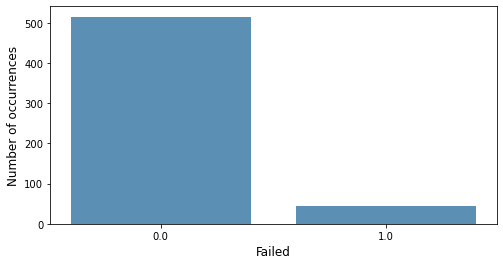

In [64]:
color = sns.color_palette()
classif = y_train['y'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Failed', fontsize=12)
plt.plot()
plt.savefig(os.path.join(reports,'imbalance.jpg'), bbox_inches = "tight")

In [65]:
counts = y['y'].value_counts()
counts

0.0    733
1.0     66
Name: y, dtype: int64

In [66]:
print('ratio between classes:',round(counts[0]/counts[1],2))
print('\r\nCheck proportions below:')
y['y'].value_counts(normalize=True)

ratio between classes: 11.11

Check proportions below:


0.0    0.917397
1.0    0.082603
Name: y, dtype: float64

# Description (2nd round)

In [67]:
if sandbox_mode:
    print(data.shape[0])
    print(y_train.shape[0])
    data.describe()

559
559


# save intermediate data

In [68]:
data.to_csv(os.path.join(outputs, 'X_train.csv'))
data_test.to_csv(os.path.join(outputs, 'X_test.csv'))

y_train.to_csv(os.path.join(outputs, 'y_train.csv'))
y_test.to_csv(os.path.join(outputs, 'y_test.csv'))